<a href="https://colab.research.google.com/github/chanelcolgate/hydroelectric-project/blob/master/Thuy_van_du_bao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import IPython
import IPython.display
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


In [2]:
%%writefile components/WindowGenerator.py

import numpy as np
import tensorflow as tf
import IPython
import IPython.display
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=None, val_df=None, test_df=None,
                 label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                                      enumerate(train_df.columns)}
        
        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    
    def split_window(self, features):
        # N: 3, A: 7, B: 19 -> A contains input_slice and labels_slice
        # slice(0, 6, None): begin: 0, size: 6, name: None
        # replace A from 7 to 6
        inputs = features[:, self.input_slice, :]
        # slice(6, None, None): begin: 6, size: None, name: None
        # replace A from 7 to 1
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)
        
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='height downstream', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)
            
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index
                
            if label_col_index is None:
                continue
            
            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=64)
                
            if n == 0:
                plt.legend()
        plt.xlabel('Time [h]')
        plt.show()
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)
        ds = ds.map(self.split_window)
        
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def example(self):
        # Get and cache an example batch of `input, label` for plotting.
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result
    
    def __repr__(self):
        return "\n".join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
        
    def __str__(self):
        return "\n".join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])    

Overwriting components/WindowGenerator.py


In [3]:
csv_path = 'data/data2.csv'

In [4]:
df = pd.read_csv(csv_path)
df.pop('flow flood')
df.head()

,height lake,height downstream,flow lake,flow downstream,time
0,83.639909,10.50,43.079927,55.111745,2018-01-01
1,83.589800,10.50,36.438755,39.453394,2018-01-02
2,83.584600,10.08,41.922042,35.819236,2018-01-03
3,83.548200,10.36,38.307749,50.513360,2018-01-04
4,83.410100,10.50,31.500019,58.925880,2018-01-05


In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
height lake,1184.0,68.481680,9.332929,53.090417,61.213554,66.794036,77.854925,85.146167
height downstream,1184.0,9.180974,1.596480,6.780000,8.180682,8.701111,9.800000,24.800000
flow lake,1184.0,42.810926,154.223147,1.134000,5.243430,9.233272,23.736297,2264.910015
flow downstream,1184.0,44.566765,118.541312,0.177480,12.052170,19.402332,41.082500,1793.359604


In [6]:
date_time = pd.to_datetime(df.pop('time'), format='%Y-%m-%d')
date_time

0      2018-01-01
1      2018-01-02
2      2018-01-03
3      2018-01-04
4      2018-01-05
          ...    
1179   2021-05-21
1180   2021-05-22
1181   2021-05-23
1182   2021-05-24
1183   2021-05-25
Name: time, Length: 1184, dtype: datetime64[ns]

In [7]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [8]:
day = 24*60*60
year = (365.2425)*day

df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Day of year signal')

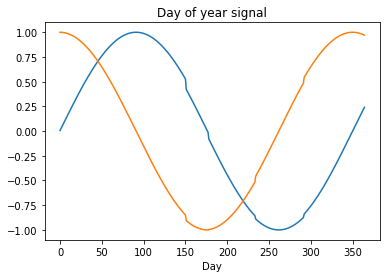

In [9]:
plt.plot(np.array(df['Year sin'])[:365])
plt.plot(np.array(df['Year cos'])[:365])
plt.xlabel('Day')
plt.title('Day of year signal')

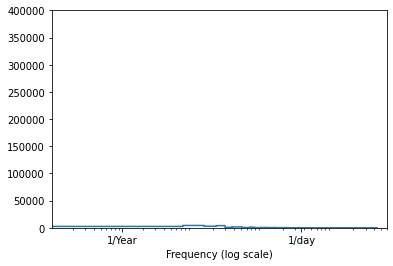

In [10]:
fft = tf.signal.rfft(df['height lake'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['height lake'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [11]:
column_indices = {name: i for i, name in enumerate(df.columns)}
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]
num_features = df.shape[1]

In [12]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

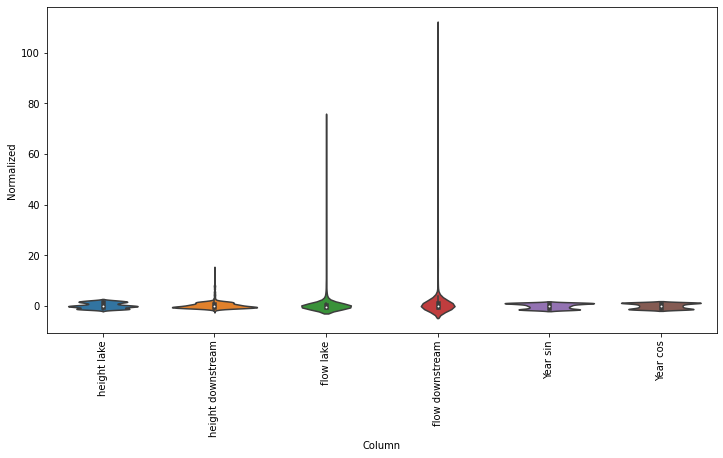

In [13]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [14]:
%%writefile components/MultiStepModels.py
import logging
import pandas as pd
import numpy as np
import tensorflow as tf
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps, num_features):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)
        
    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)
        
        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state
    
    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the lstm state
        prediction, state = self.warmup(inputs)
        
        # Insert the first prediction
        predictions.append(prediction)
        
        # Run the test of the prediction steps
        for n in range(1, self.out_steps):
            # Use the last prediction as input
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state, training=training)
            # Convert the lstm output to a prediction
            prediciton = self.dense(x)
            # Add the prediction to the output
            predictions.append(prediction)
            
        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

class MultiStepLastBaseline(tf.keras.Model):
    def __init__(self, out_steps):
        super().__init__()
        self.out_steps = out_steps
    
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, self.out_steps, 1])

class RepeatBaseLine(tf.keras.Model):
    def call(self, inputs):
        return inputs

class MultiStepModels():
    MAX_EPOCHS = 20
    def __init__(self, out_steps, num_features, conv_width, multi_window, plot_col):
        self.out_steps = out_steps
        self.multi_window = multi_window
        self.conv_width = conv_width
        self.num_features = num_features
        self.plot_col = plot_col
        
    def compile_and_fit(self, model, window, patience=2):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                          patience=patience,
                                                          mode='min')
        model.compile(loss=tf.losses.MeanSquaredError(),
                      optimizer=tf.optimizers.Adam(),
                      metrics=[tf.metrics.MeanAbsoluteError()])
        history = model.fit(window.train, epochs=self.MAX_EPOCHS,
                            validation_data = window.val,
                            callbacks=[early_stopping])
        return history
        
    def startApp(self):
        # # Baselines
        # last_baseline = MultiStepLastBaseline(self.out_steps)
        # last_baseline.compile(loss=tf.losses.MeanSquaredError(),
        #                       metrics=[tf.metrics.MeanAbsoluteError()])
        
        multi_val_performance = {}
        multi_performance = {}
        
        # multi_val_performance['Last'] = last_baseline.evaluate(self.multi_window.val)
        # multi_performance['Last'] = last_baseline.evaluate(self.multi_window.test, verbose=0)
        # plot1 = self.multi_window.plot(last_baseline, plot_col=self.plot_col)
        
        # # Repeat baselines
        # repeat_baseline = RepeatBaseLine()
        # repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
        #                         metrics=[tf.metrics.MeanAbsoluteError()])
        
        # multi_val_performance['Repeat'] = repeat_baseline.evaluate(self.multi_window.val)
        # multi_performance['Repeat'] = repeat_baseline.evaluate(self.multi_window.test, verbose=0)
        # plot2 = self.multi_window.plot(repeat_baseline, plot_col=self.plot_col)
        
        # Linear
        # multi_linear_model = tf.keras.Sequential([
        #     #Take the last time-step.
        #     # Shape [batch, time, feature] => [batch, 1, features]
        #     tf.keras.layers.Lambda(lambda x: x[:, -1, :]),
        #     # Shape => [batch, 1, out_steps*features]
        #     tf.keras.layers.Dense(self.out_steps*self.num_features,
        #                           kernel_initializer=tf.initializers.zeros()),
        #     # Shape => [batch, out_steps, features]
        #     tf.keras.layers.Reshape([self.out_steps, self.num_features])])
        
        # history = self.compile_and_fit(multi_linear_model, self.multi_window)
        # IPython.display.clear_output()
        
        # multi_val_performance['Linear'] = multi_linear_model.evaluate(self.multi_window.val)
        # multi_performance['Linear'] = multi_linear_model.evaluate(self.multi_window.test, verbose=0)
        # plot3 = self.multi_window.plot(multi_linear_model, plot_col=self.plot_col)
        
        # # CNN
        # multi_conv_model = tf.keras.Sequential([
        #     # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
        #     tf.keras.layers.Lambda(lambda x: x[: , -self.conv_width:, :]),
        #     # Shape => [batch, 1, conv_units]
        #     tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(self.conv_width)),
        #     # Shape => [batch, 1, out_steps*features]
        #     tf.keras.layers.Dense(self.out_steps*self.num_features,
        #                           kernel_initializer=tf.initializers.zeros()),
        #     # Shape => [batch, out_steps, features]
        #     tf.keras.layers.Reshape([self.out_steps, self.num_features])])
        
        # history = self.compile_and_fit(multi_conv_model, self.multi_window)
        # IPython.display.clear_output()
        
        # multi_val_performance['Conv'] = multi_conv_model.evaluate(self.multi_window.val)
        # multi_performance['Conv'] = multi_conv_model.evaluate(self.multi_window.test, verbose=0)
        # plot4 = self.multi_window.plot(multi_conv_model, plot_col=self.plot_col)
        
        # RNN
        multi_lstm_model = tf.keras.Sequential([
            # Shape [batch, time, features] => [batch, lstm_units]
            # Adding more `lstm_units` just overfits more quickly.
            tf.keras.layers.LSTM(128, return_sequences=False),
            # Shape => [batch, out_steps*features]
            tf.keras.layers.Dense(self.out_steps*self.num_features,
                                  kernel_initializer=tf.initializers.zeros()),
            # Shape => [batch, out_steps, features]
            tf.keras.layers.Reshape([self.out_steps, self.num_features])
            ])
        
        history = self.compile_and_fit(multi_lstm_model, self.multi_window)
        IPython.display.clear_output()
        
        multi_val_performance['LSTM'] = multi_lstm_model.evaluate(self.multi_window.val)
        multi_performance['LSTM'] = multi_lstm_model.evaluate(self.multi_window.test, verbose=0)
        multi_lstm_model.save('saved_model/multi_lstm_model')
        plot5 = self.multi_window.plot(multi_lstm_model, plot_col=self.plot_col)
        
        # Advanced: Autogressive model
        # RNN
        # feedback_model = FeedBack(units=32, out_steps=self.out_steps, num_features=self.num_features)
        # history = self.compile_and_fit(feedback_model, self.multi_window)
        # IPython.display.clear_output()
        
        # multi_val_performance['AR LSTM'] = feedback_model.evaluate(self.multi_window.val)
        # multi_performance['AR LSTM'] = feedback_model.evaluate(self.multi_window.test, verbose=0)
        # plot6 = self.multi_window.plot(feedback_model, plot_col=self.plot_col)
        
        # Performance
        x = np.arange(len(multi_performance))
        width = 0.3
        
        metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
        val_mae = [v[metric_index] for v in multi_val_performance.values()]
        test_mae = [v[metric_index] for v in multi_performance.values()]
        
        plt.bar(x - 0.17, val_mae, width, label='Validation')
        plt.bar(x + 0.17, test_mae, width, label='Test')
        plt.xticks(ticks=x, labels=multi_performance.keys(), rotation=45)
        plt.ylabel(f'MAE (average over all times and outputs)')
        _ = plt.legend()
        plt.show()

Overwriting components/MultiStepModels.py


In [15]:
from components.MultiStepModels import MultiStepModels
from components.WindowGenerator import WindowGenerator

In [16]:
#@title Create window for train, validation, test {display-mode: "form"}
label_column = "flow lake"  #@param {type: "string"}

label_columns = []
label_columns.append(label_column)

OUT_STEPS = 1
CONV_WIDTH = 3
multi_window = WindowGenerator(
    input_width=90,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=label_columns
)

multiStepModels = MultiStepModels(out_steps=OUT_STEPS,num_features=num_features,conv_width=CONV_WIDTH,multi_window=multi_window,plot_col=label_column)

5/5 [==============================] - 0s 22ms/step - loss: 172.0873 - mean_absolute_error: 5.5313


INFO:tensorflow:Assets written to: saved_model/multi_lstm_model/assets


INFO:tensorflow:Assets written to: saved_model/multi_lstm_model/assets


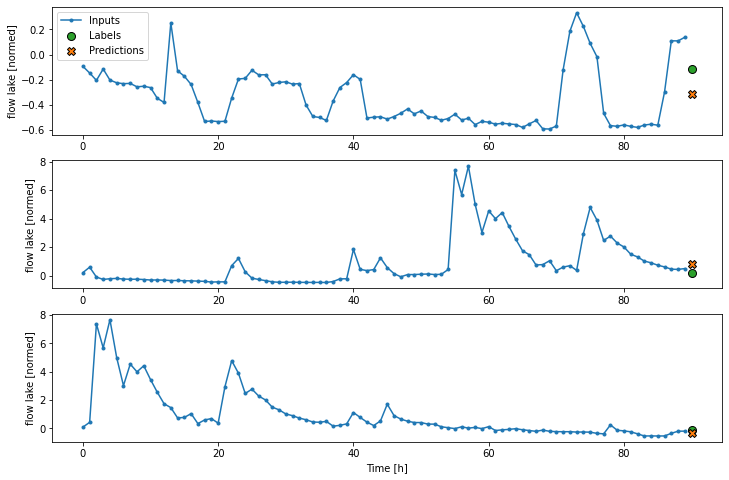

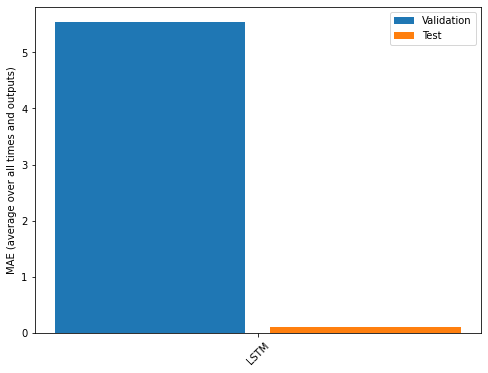

In [17]:
multiStepModels.startApp()

In [18]:
# Save the entire model as a SavedModel.
#!mkdir -p saved_model
new_model = tf.keras.models.load_model('saved_model/multi_lstm_model')

# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               69120     
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
_________________________________________________________________
reshape (Reshape)            (None, 1, 6)              0         
Total params: 69,894
Trainable params: 69,894
Non-trainable params: 0
_________________________________________________________________


In [19]:
# import json
# inference_fn = new_model.signatures['serving_default']
# Prepare an example and run inference.
# features = json.loads(test_df.loc[1065, :].to_json())
# features = {
#     'Year cos': tf.train.Feature(float_list=tf.train.FloatList(value=[features['Year cos']])),
#     'Year sin': tf.train.Feature(float_list=tf.train.FloatList(value=[features['Year sin']])),
#     'flow downstream': tf.train.Feature(float_list=tf.train.FloatList(value=[features['flow downstream']])),
#     'flow lake': tf.train.Feature(float_list=tf.train.FloatList(value=[features['flow lake']])),
#     'height downstream': tf.train.Feature(float_list=tf.train.FloatList(value=[features['height downstream']])),
#     'height lake': tf.train.Feature(float_list=tf.train.FloatList(value=[features['height lake']])),
# }
# example_proto = tf.train.Example(features=tf.train.Features(feature=features))
# examples = example_proto.SerializeToString()

# result = inference_fn(examples=tf.constant([examples]))
# print(result['output_0'].numpy())

In [20]:
pred_df = pd.DataFrame(test_df.loc[1065:1065+90-1, :])
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    train_df=pred_df,
    val_df=pred_df,
    test_df=pred_df,
    label_columns=['flow downstream'])
input, _ = single_step_window.example

In [21]:
column_indices = {name: i for i, name in
                  enumerate(pred_df.columns)}
plot_col_index = column_indices['flow downstream']

In [22]:
predictions = new_model(input)
val = predictions[0, :, plot_col_index]

In [23]:
val = val.numpy()*train_std + train_mean

In [24]:
val

height lake          67.199140
height downstream     8.893090
flow lake            20.314482
flow downstream      22.435760
Year sin              0.174795
Year cos              0.085264
dtype: float64

In [25]:
pd.DataFrame(df.loc[1065+90-1, :]).transpose()

,height lake,height downstream,flow lake,flow downstream,Year sin,Year cos
1154,68.7236,7.91,7.431919,12.15936,0.913739,-0.406302


In [29]:
import json
json.loads(val.to_json())

{'Year cos': 0.0852636276,
 'Year sin': 0.1747946294,
 'flow downstream': 22.4357602149,
 'flow lake': 20.3144824428,
 'height downstream': 8.8930904969,
 'height lake': 67.1991396165}